In [253]:
# Imports
import os
from pathlib import Path
from dotenv import load_dotenv
import datetime
from datetime import date
import pandas as pd
import hvplot.pandas
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from statsmodels.tsa.arima_model import ARMA, ARIMA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import warnings
warnings.filterwarnings("ignore")

In [254]:
# Set the random seed for reproducibility
from numpy.random import seed
seed(42)
from tensorflow import random
random.set_seed(42)

# Cleaning Data

In [255]:
# Importing CSV, Reading CSV, and establishing a DataFrame obj.
path = Path("../Project-2-group-3/close_prices.csv")
data = pd.read_csv(path, parse_dates=["Unnamed: 0"])
df = pd.DataFrame(data)

# Cleaning Date Column
df.rename(columns={"Unnamed: 0":"Date"}, inplace=True)
df['Date'] = df['Date'].apply(lambda t: t.strftime('%Y-%m-%d'))

# Setting the Index and dropping the extra colum
df.set_index(pd.DatetimeIndex(df['Date']), inplace=True)
df.drop(columns=['Date'], inplace=True)

# Making the values stationary, using .diff()
for ticker in df.columns.values:
    df[f"{ticker} Diff"] = df[f"{ticker}"].diff()
    df[f"{ticker} Daily Returns"] = df[f"{ticker}"].pct_change()
    df[f"{ticker} Lagged"] = df[f"{ticker} Daily Returns"].shift()
    
# Dropping NA values of first row
df.dropna(inplace=True)

# Seperate DataFrames
daily_returns_df = df[["AMZN Daily Returns","BRK.B Daily Returns","K Daily Returns","MSFT Daily Returns","XOM Daily Returns"]]
lagged_df = df[["AMZN Lagged","BRK.B Lagged","K Lagged","MSFT Lagged","XOM Lagged"]]
stationary_df = df[["AMZN Diff","BRK.B Diff","K Diff","MSFT Diff","XOM Diff"]]

In [256]:
# Quick look at DataFrame
df.head()

,AMZN,BRK.B,K,MSFT,XOM,AMZN Diff,AMZN Daily Returns,AMZN Lagged,BRK.B Diff,BRK.B Daily Returns,BRK.B Lagged,K Diff,K Daily Returns,K Lagged,MSFT Diff,MSFT Daily Returns,MSFT Lagged,XOM Diff,XOM Daily Returns,XOM Lagged
Date,,,,,,,,,,,,,,,,,,,,
2015-01-06,295.29,146.70,64.43,45.60,89.78,-6.81,-0.02,-0.02,-0.37,-0.00,-0.01,0.16,0.00,-0.02,-0.73,-0.02,-0.01,-0.56,-0.01,-0.03
2015-01-07,298.42,148.81,66.00,46.23,90.72,3.13,0.01,-0.02,2.11,0.01,-0.00,1.57,0.02,0.00,0.63,0.01,-0.02,0.94,0.01,-0.01
2015-01-08,300.46,151.25,67.19,47.59,92.20,2.04,0.01,0.01,2.44,0.02,0.01,1.19,0.02,0.02,1.36,0.03,0.01,1.48,0.02,0.01
2015-01-09,296.93,149.53,66.44,47.19,92.11,-3.53,-0.01,0.01,-1.72,-0.01,0.02,-0.75,-0.01,0.02,-0.40,-0.01,0.03,-0.09,-0.00,0.02
2015-01-12,291.40,148.33,65.50,46.61,90.41,-5.53,-0.02,-0.01,-1.20,-0.01,-0.01,-0.94,-0.01,-0.01,-0.58,-0.01,-0.01,-1.70,-0.02,-0.00


# Create Features 'X' and Target 'y'

* We will set the 'X' features to the shifted percent change and 'y' features to the daily percent change

* We will then split our data 75% training and 25% testing

* Run our models on the training and test data to ensure we do not overfit 


In [257]:
#Create 'X' Features based on lagged returns
x_cols = [i for i in df.columns if i not in ('AMZN', 'BRK.B', 'K', 'MSFT', 'XOM', 
                                             'AMZN Diff', 'AMZN Daily_returns',
                                             'BRK.B Diff', 'BRK.B Daily_returns',
                                             'K Diff', 'K Daily_returns', 
                                             'MSFT Diff','MSFT Daily_returns', 
                                             'XOM Diff', 'XOM Daily_returns',)]
X = df[x_cols]

#Create 'y' Features based on percent change daily returns
y_cols = [x for x in df.columns if x not in ('AMZN', 'BRK.B', 'K', 'MSFT', 'XOM', 
                                             'AMZN Diff', 'AMZN Lagged',
                                             'BRK.B Diff', 'BRK.B Lagged',
                                             'K Diff', 'K Lagged', 
                                             'MSFT Diff','MSFT Lagged', 
                                             'XOM Diff', 'XOM Lagged',)]
y = df[y_cols]

In [258]:
#Split 'X' and 'y' data into 75% training and 25% testing
split = int(0.75 * len(X))
X_train_all = X[:split]
X_test_all = X[split:]
y_train_all = y[:split]
y_test_all = y[split:]

# Stationarity

<AxesSubplot:xlabel='Date'>

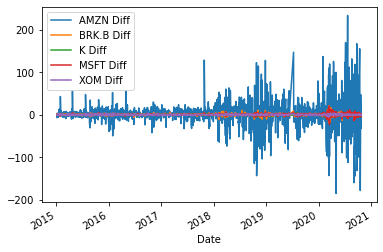

In [259]:
# Look at plot of stationary plot data
stationary_df.plot()

### Finding optimal parameters

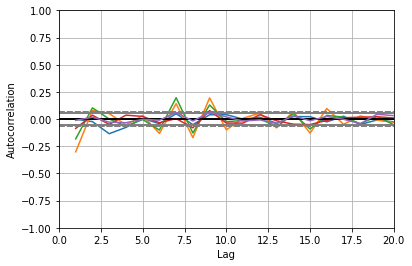

In [260]:
#ARIMA(p,d,q)
# p = number of lag observations included in the model, lag order
# d = number of times the raw observations are differenced, degree of differencing
# q = the size of the moving average window, order of maving average

#Autocorrelation Plots to determine optimal (p) lag order of ARIMA model

k_ac_plot = autocorrelation_plot(stationary_df['K Diff']).set_xlim([0,20]) #blue
msft_ac_plot = autocorrelation_plot(stationary_df['MSFT Diff']).set_xlim([0,20]) #orange
brkb_ac_plot = autocorrelation_plot(stationary_df['BRK.B Diff']).set_xlim([0,20]) #green
amzn_ac_plot = autocorrelation_plot(stationary_df['AMZN Diff'], ).set_xlim([0,20]) #red
xom_ac_plot = autocorrelation_plot(stationary_df['XOM Diff']).set_xlim([0,20])

# Autocorrelation & Partial Autocorrelation

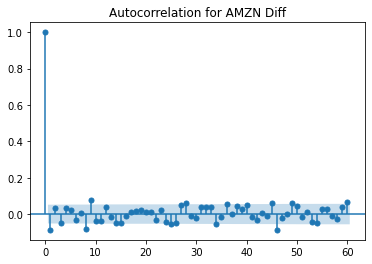

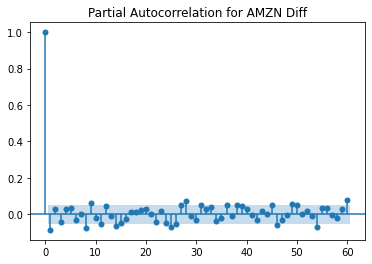

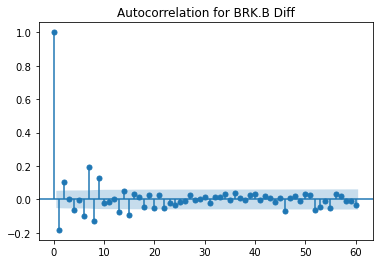

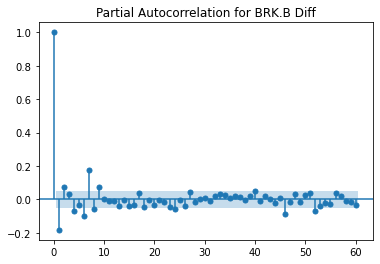

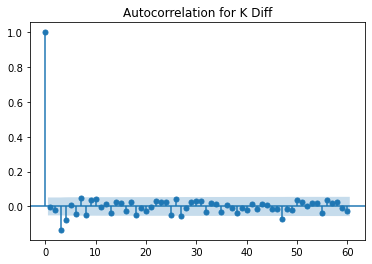

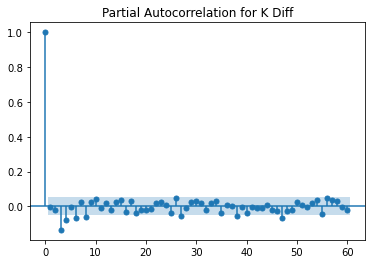

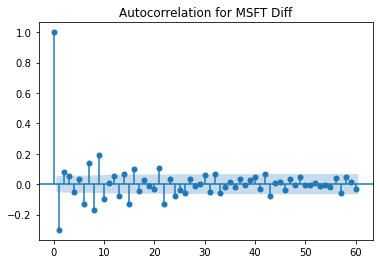

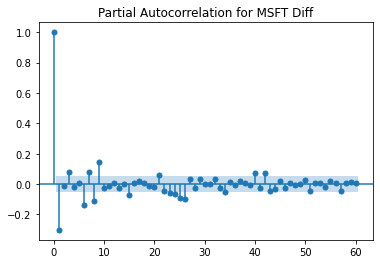

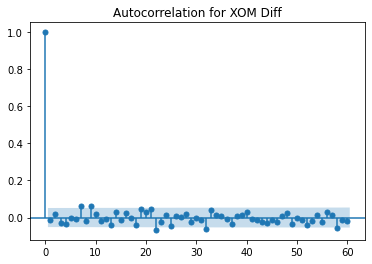

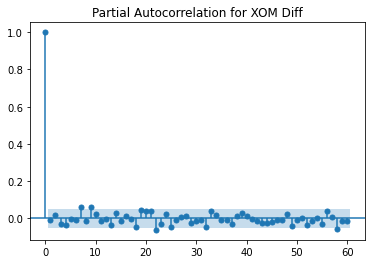

In [261]:
# Plot the autocorrelation of the stocks closing prices to determine lags
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

counter = 0

while len(stationary_df.columns.values) != counter:
    arma_acf = plot_acf(stationary_df[stationary_df.columns[counter]].values, title=f"Autocorrelation for {stationary_df.columns[counter]}", zero=True, lags=60)
    arma_pacf = plot_pacf(stationary_df[stationary_df.columns[counter]].values, title=f"Partial Autocorrelation for {stationary_df.columns[counter]}", zero=True, lags=60)
    counter += 1 

# ARIMA Models

In [262]:
def arima(df_series_obj, split_size=0.75, p=2, d=1, q=0):
    """
    Takes in a pandas.series object and creates an ARIMA model around the values given
    
    Default Train/Test split is 75/25
    
    Default ARIMA(p,d,q) = (7,1,0)
    
    (If closing prices and passed, RMSE & MSE will be in USD.)
    """
    # Establish X Feature as series values
    X = df_series_obj.values
    
    # Train/Test/Split Size
    size = int(len(X) * split_size)
    train, test = X[0:size], X[size:len(X)]
    
    # Number of Predictions
    #print(f"Number of Predictions to run: {len(test)}")
    
    #History of close values
    history = [x for x in train]
    
    #Empty Predictions list for appending forecasted values
    predictions = list()
    
    #Loop through Test set and compare predicted with expected values
    for t in range(len(test)):
        model = ARIMA(history, order=(p,d,q))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        
        # Print Function Commented out to clean output
        #print('predicted=%.2f, expected=%.2f' %(yhat, obs))
    
    # Figure out MSE/RMSE error report
    error = mean_squared_error(test, predictions)
    rmse = np.sqrt(error)
    
    # Setting up empty predicted price list
    pred_list = []

    # Going through the previous list of arrays and appending prices to a list
    for arrays in predictions:
        for numbers in arrays:
            pred_list.append(numbers)

    # Create DataFrame column of predicted Prices
    stock_pred_df = pd.DataFrame(data={f'{df_series_obj.name} Predicted Prices':pred_list},
                                    index=df_series_obj.index[size:len(df_series_obj)])
    
    # Append/Concatenate DataFrame to Master DataFrame
    df[f'{df_series_obj.name} Predicted ARIMA Prices'] = stock_pred_df  
    
    # Print Error report in dollar values
    print(f'Results for {df_series_obj.name}')
    print('Test MSE of: %.3f' % error)
    print('Test RMSE of: %.3f' % rmse)
    
    print(model_fit.summary())
    
    # Return plot of performance
    plt.title(f"Plot for {df_series_obj.name}")
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.show()
    
    pass

Results for MSFT
Test MSE of: 14.463
Test RMSE of: 3.803
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1443
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -3123.203
Method:                       css-mle   S.D. of innovations              2.107
Date:                Thu, 26 Nov 2020   AIC                           6254.405
Time:                        18:28:20   BIC                           6275.503
Sample:                             1   HQIC                          6262.280
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1172      0.042      2.785      0.005       0.035       0.200
ar.L1.D.y     -0.3052      0.026    -11.596      0.000      -0.357      -0

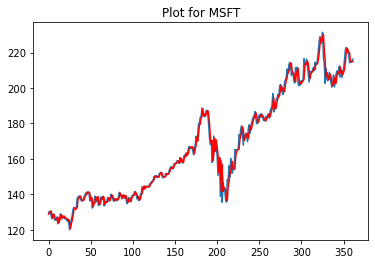

Results for K
Test MSE of: 1.372
Test RMSE of: 1.171
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1443
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1928.941
Method:                       css-mle   S.D. of innovations              0.921
Date:                Thu, 26 Nov 2020   AIC                           3865.882
Time:                        18:28:40   BIC                           3886.979
Sample:                             1   HQIC                          3873.756
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.024      0.054      0.957      -0.045       0.048
ar.L1.D.y     -0.0015      0.026     -0.058      0.954      -0.053       0.050

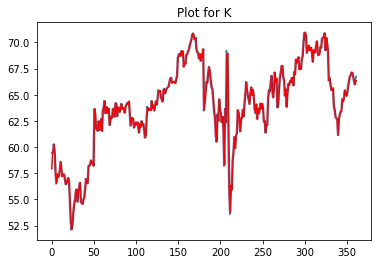

Results for AMZN
Test MSE of: 2635.525
Test RMSE of: 51.337
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1443
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -7035.071
Method:                       css-mle   S.D. of innovations             31.702
Date:                Thu, 26 Nov 2020   AIC                          14078.142
Time:                        18:29:09   BIC                          14099.240
Sample:                             1   HQIC                         14086.017
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9969      0.791      2.523      0.012       0.446       3.548
ar.L1.D.y     -0.0834      0.026     -3.170      0.002      -0.135     

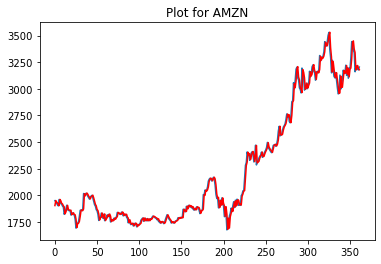

Results for XOM
Test MSE of: 1.551
Test RMSE of: 1.245
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1443
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -2109.399
Method:                       css-mle   S.D. of innovations              1.044
Date:                Thu, 26 Nov 2020   AIC                           4226.797
Time:                        18:29:26   BIC                           4247.895
Sample:                             1   HQIC                          4234.672
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0380      0.028     -1.373      0.170      -0.092       0.016
ar.L1.D.y     -0.0102      0.026     -0.386      0.699      -0.062       0.0

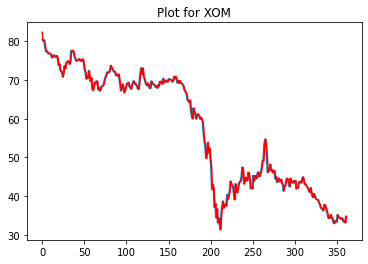

Results for BRK.B
Test MSE of: 12.508
Test RMSE of: 3.537
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1443
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -3304.948
Method:                       css-mle   S.D. of innovations              2.390
Date:                Thu, 26 Nov 2020   AIC                           6617.895
Time:                        18:29:41   BIC                           6638.993
Sample:                             1   HQIC                          6625.770
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0449      0.057      0.783      0.434      -0.068       0.157
ar.L1.D.y     -0.1690      0.026     -6.437      0.000      -0.221      -

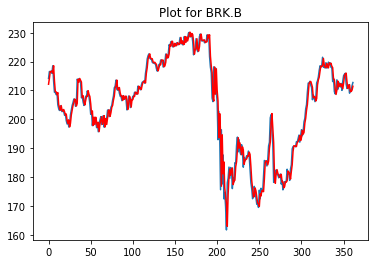

In [263]:
msft_arima = arima(df['MSFT'])
k_arima = arima(df['K'])
amzn_arima = arima(df['AMZN'])
xom_arima = arima(df['XOM'])
brkb_arima = arima(df['BRK.B'])

# Linear Regression Models

In [264]:
def linearRegression(stock_close_series, df_split=0.75):
    """
    Takes in a pandas.Series object of stock closing prices
    Splits the data 75% training, 25% testing
    Uses a LinearRegression model
    Returns RMSE score
    
    Requires:
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error, r2_score
    """
    
    # Turn series into DF
    lin_df = stock_close_series.to_frame()
    lin_df.dropna(inplace=True)
    #Create Return & Lagged Return columns
    for ticker in lin_df.columns.values:
        lin_df[f"{ticker} Return"] = lin_df[f"{ticker}"].pct_change() * 100
        lin_df[f"{ticker} Lagged Return"] = lin_df[f"{ticker} Return"].shift()
    
    #Drop NA values
    lin_df.dropna(inplace=True)
    
    #Creating Split variable
    split = int(len(df) * df_split)
    
    #Create LinearRegression Model Object
    model = LinearRegression()
    
    #Establishing X & y
    y = lin_df[f"{ticker} Return"].to_frame()
    X = lin_df[f"{ticker} Lagged Return"].to_frame()
    
    #Train/Test Split
    X_train = X[:split]
    y_train = y[:split]
    X_test = X[split:]
    y_test = y[split:]
    
    #Fit training data
    model.fit(X_train, y_train)
    
    #Make predictions on X_test
    predictions = model.predict(X_test)
    
    # Results 
    results = y_test
    results[f"{ticker} Predicted Return"] = predictions
    
    #Plot of Predicted vs Returns
    plot = results.plot(subplots=True)
    
    #MSE
    mse = mean_squared_error(
    results[f"{ticker} Return"],
    results[f"{ticker} Predicted Return"])
    
    #RMSE
    rmse = np.sqrt(mse)
    
    print(f"Root Mean Squared Error (RMSE) {ticker}: {rmse}")
    
    return plot

Root Mean Squared Error (RMSE) K: 1.8491673872746317
Root Mean Squared Error (RMSE) AMZN: 2.1407185908514825
Root Mean Squared Error (RMSE) MSFT: 2.333412742104696
Root Mean Squared Error (RMSE) BRK.B: 1.8606680228311345
Root Mean Squared Error (RMSE) XOM: 2.655196366324129


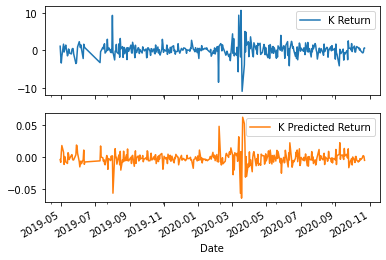

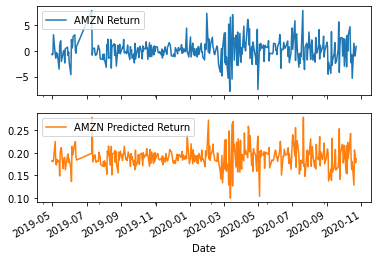

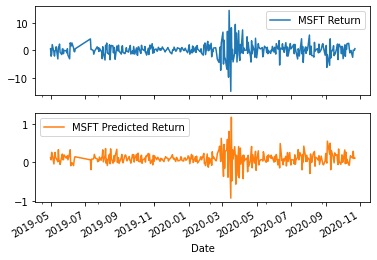

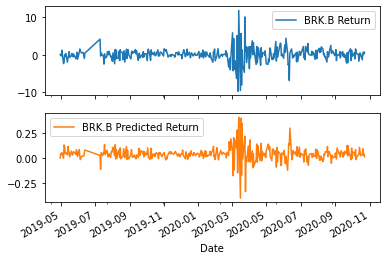

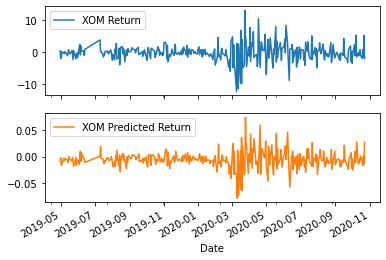

In [265]:
kel_lin = linearRegression(df['K'])
amzn_lin = linearRegression(df['AMZN'])
msft_lin = linearRegression(df['MSFT'])
brkb_lin = linearRegression(df['BRK.B'])
xom_lin = linearRegression(df['XOM'])

In [266]:
df

,AMZN,BRK.B,K,MSFT,XOM,AMZN Diff,AMZN Daily Returns,AMZN Lagged,BRK.B Diff,BRK.B Daily Returns,...,MSFT Daily Returns,MSFT Lagged,XOM Diff,XOM Daily Returns,XOM Lagged,MSFT Predicted ARIMA Prices,K Predicted ARIMA Prices,AMZN Predicted ARIMA Prices,XOM Predicted ARIMA Prices,BRK.B Predicted ARIMA Prices
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-06,295.29,146.70,64.43,45.60,89.78,-6.81,-0.02,-0.02,-0.37,-0.00,...,-0.02,-0.01,-0.56,-0.01,-0.03,nan,nan,nan,nan,nan
2015-01-07,298.42,148.81,66.00,46.23,90.72,3.13,0.01,-0.02,2.11,0.01,...,0.01,-0.02,0.94,0.01,-0.01,nan,nan,nan,nan,nan
2015-01-08,300.46,151.25,67.19,47.59,92.20,2.04,0.01,0.01,2.44,0.02,...,0.03,0.01,1.48,0.02,0.01,nan,nan,nan,nan,nan
2015-01-09,296.93,149.53,66.44,47.19,92.11,-3.53,-0.01,0.01,-1.72,-0.01,...,-0.01,0.03,-0.09,-0.00,0.02,nan,nan,nan,nan,nan
2015-01-12,291.40,148.33,65.50,46.61,90.41,-5.53,-0.02,-0.01,-1.20,-0.01,...,-0.01,-0.01,-1.70,-0.02,-0.00,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-19,3207.30,209.05,66.70,214.24,33.42,47.30,0.01,-0.05,-2.89,-0.01,...,-0.02,-0.00,-0.69,-0.02,-0.01,219.83,67.10,3175.52,34.08,212.01
2020-10-20,3216.26,209.95,66.25,214.56,33.71,8.96,0.00,0.01,0.90,0.00,...,0.00,-0.02,0.29,0.01,-0.02,216.05,66.70,3199.73,33.38,209.61
2020-10-21,3183.60,210.03,65.96,214.78,33.16,-32.66,-0.01,0.00,0.08,0.00,...,0.00,0.00,-0.55,-0.02,0.01,214.69,66.26,3219.07,33.66,209.64


# RNN LSTM Models

In [267]:
def rnnLSTM(stock_close_series, train_size=0.60, window_size=10, epoch_len=10, learning_rate=3e-3):
    """
    Function creates and fits an RNN LSTM model to stock_close_series data, which
    should be in the form of a pandas.Series object.
    
    Window size is equal to number of units in the Sequential model.
    """
    rnn_df = stock_close_series.to_frame()
    
    # The feature and target columns will be the only columns of the Series/DataFrame
    # which is passed as a parameter of the function
    feature_col_number = 0
    target_col_number = 0
    
    # Establishing Feature and Label
    X = []
    y = []
    
    for i in range(len(rnn_df) - window_size):
        features = rnn_df.iloc[i : (i + window_size), feature_col_number]
        target = rnn_df.iloc[(i + window_size), target_col_number]
        X.append(features)
        y.append(target)
    
    X, y = np.array(X), np.array(y).reshape(-1, 1)
    
    # Establishing Split size
    split = int(train_size * len(X))
    
    #Train/Test Split
    X_train = X[: split]
    X_test = X[split:]
    y_train = y[: split]
    y_test = y[split:]
        
    #Scaling & Fitting the Data
    scaler = MinMaxScaler()
    scaler.fit(X)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    scaler.fit(y)
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)
    
    #Reshape Features
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    # Define the LSTM RNN model.
    model = Sequential()

    # Initial model setup
    # number_units should be equal to window_size
    dropout_fraction = 0.5

    # Layer 1
    model.add(LSTM(
        units=window_size,
        return_sequences=True,
        input_shape=(X_train.shape[1], 1))
        )
    model.add(Dropout(dropout_fraction))

    # Layer 2
    model.add(LSTM(units=3*window_size, return_sequences=True))
    model.add(Dropout(dropout_fraction))

    # Layer 3
    model.add(LSTM(units=2*window_size, return_sequences=True))
    model.add(Dropout(dropout_fraction))
    
    # Layer 4
    model.add(LSTM(units=1*window_size))
    model.add(Dropout(dropout_fraction))

    # Output layer
    model.add(Dense(1))
    
    # Optimizer
    #optimizer = keras.optimizers.SGD(lr=learning_rate)
    
    # Compile the model
    model.compile(optimizer='adam', loss="mean_squared_error")
    
    # Model summary
    #model.summary()
    
    # Fit model
    model.fit(X_train, y_train, epochs=epoch_len, shuffle=False, batch_size=90, verbose=1)
    
    # Evaluate model
    evaluation = model.evaluate(X_test, y_test, verbose=0)
    print("\n")
    print(evaluation)
    
    # Make predictions using the testing data X_test
    predicted = model.predict(X_test)
    
    # Recover the original prices instead of the scaled version
    predicted_prices = scaler.inverse_transform(predicted)
    real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Create a DataFrame of Real and Predicted values
    stocks = pd.DataFrame({
        f"{stock_close_series.name} Actual": real_prices.ravel(),
        f"{stock_close_series.name} RNN Predicted": predicted_prices.ravel()
    }, index = rnn_df.index[-len(real_prices): ]) 
    
    # Plot the real vs predicted prices as a line chart
    #stocks.plot(title=f"Actual Vs. Predicted {stock_close_series.name} Price")
    
    #Append predicted prices to master DF.
    df[f"{stock_close_series.name} Predicted RNN Prices"] = stocks[f"{stock_close_series.name} RNN Predicted"]
    
    plt.title(f"Plot of Test Data for {stock_close_series.name}")
    plt.plot(stocks)
    plt.plot(predicted_prices, color='red')
    plt.xlim([stocks.index[0], stocks.index[-1]])
    plt.show() 
    
    pass

Epoch 1/10
10/10 [==============================] - 0s 23ms/step - loss: 0.0082
Epoch 2/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0116
Epoch 3/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0096
Epoch 4/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0078
Epoch 5/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0070
Epoch 6/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0066
Epoch 7/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0049
Epoch 8/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0035
Epoch 9/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0025
Epoch 10/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0028


0.002589695155620575


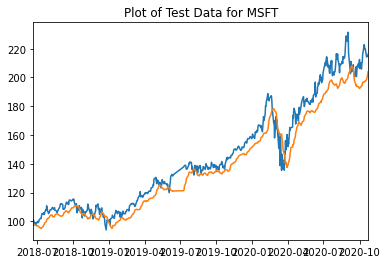

Epoch 1/10
10/10 [==============================] - 0s 23ms/step - loss: 0.5046
Epoch 2/10
10/10 [==============================] - 0s 20ms/step - loss: 0.2049
Epoch 3/10
10/10 [==============================] - 0s 20ms/step - loss: 0.1253
Epoch 4/10
10/10 [==============================] - 0s 19ms/step - loss: 0.1123
Epoch 5/10
10/10 [==============================] - 0s 18ms/step - loss: 0.1014
Epoch 6/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0992
Epoch 7/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0946
Epoch 8/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0928
Epoch 9/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0874
Epoch 10/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0775


0.037073180079460144


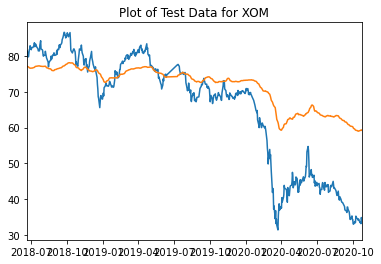

Epoch 1/10
10/10 [==============================] - 0s 23ms/step - loss: 0.1053
Epoch 2/10
10/10 [==============================] - 0s 20ms/step - loss: 0.0508
Epoch 3/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0435
Epoch 4/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0485
Epoch 5/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0365
Epoch 6/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0317
Epoch 7/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0270
Epoch 8/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0244
Epoch 9/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0199
Epoch 10/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0213


0.006998436059802771


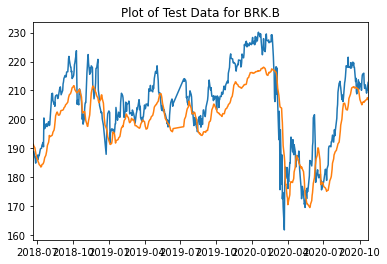

Epoch 1/10
10/10 [==============================] - 0s 23ms/step - loss: 0.0179
Epoch 2/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0125
Epoch 3/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0138
Epoch 4/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0126
Epoch 5/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0107
Epoch 6/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0102
Epoch 7/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0091
Epoch 8/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0072
Epoch 9/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0062
Epoch 10/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0054


0.003545408369973302


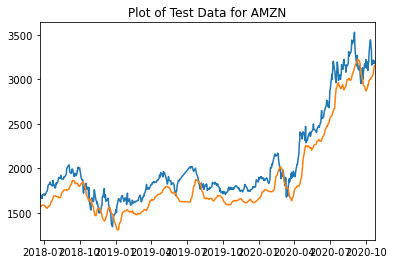

Epoch 1/10
10/10 [==============================] - 0s 23ms/step - loss: 0.2442
Epoch 2/10
10/10 [==============================] - 0s 19ms/step - loss: 0.1295
Epoch 3/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0668
Epoch 4/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0540
Epoch 5/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0492
Epoch 6/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0489
Epoch 7/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0460
Epoch 8/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0442
Epoch 9/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0409
Epoch 10/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0373


0.011165439151227474


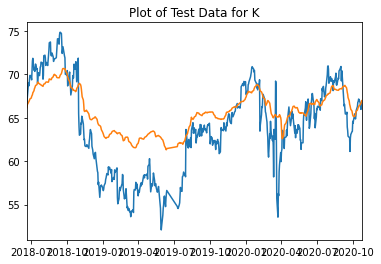

In [268]:
msft_rnn = rnnLSTM(df['MSFT'])
xom_rnn = rnnLSTM(df['XOM'])
brkb_rnn = rnnLSTM(df['BRK.B']) 
amzn_rnn = rnnLSTM(df['AMZN'])
k_rnn = rnnLSTM(df['K'])

# ARMA Models Take One

In [269]:
#ARMA Imports
from statsmodels.tsa.arima_model import ARMA

# First Loop to create & fit the models, and then append them to a list. Use order (1,1)
counter = 0
arma_results_list = []

while len(stationary_df.columns.values) != counter:
    arma_model = ARMA(stationary_df[stationary_df.columns[counter]].values, order=(1,1))
    arma_results = arma_model.fit()
    arma_results_list.append(arma_results)
    counter += 1
    
# Second loop to print the resulting summaries of the ARMA models    
counter_2 = 0

while len(stationary_df.columns.values) != counter_2:
    for arma_results in arma_results_list:
        print("\n")
        print(f"ARMA Model results for: {stationary_df.columns[counter_2]}")
        print("\n")
        print(arma_results.summary())
        counter_2 += 1



ARMA Model results for: AMZN Diff


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1445
Model:                     ARMA(1, 1)   Log Likelihood               -7043.416
Method:                       css-mle   S.D. of innovations             31.671
Date:                Thu, 26 Nov 2020   AIC                          14094.832
Time:                        18:30:42   BIC                          14115.935
Sample:                             0   HQIC                         14102.708
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0081      0.788      2.547      0.011       0.463       3.553
ar.L1.y       -0.5281      0.159     -3.319      0.001      -0.840      -0.216
ma.L1.y       

In [270]:
def createCrossovers(df=df):
    """
    Takes in the DF of tickers, RNN predicted prices, and ARIMA predicted prices
    and returns crossover signals for each stock.
    """
    

    num_tickers = int(input("How many tickers are in your portfolio?: "))

    for ticker in df.columns[:num_tickers]: 
        df[f'{ticker} RNN crossover_long'] = np.where(df[f'{ticker}'] > df[f'{ticker} Predicted RNN Prices'], 1.0, 0.0)
        df[f'{ticker} RNN crossover_short'] = np.where(df[f'{ticker}'] < df[f'{ticker} Predicted RNN Prices'], -1.0, 0.0)
        df[f'{ticker} RNN crossover_signal'] = df[f'{ticker} RNN crossover_long'] + df[f'{ticker} RNN crossover_short']

    for ticker in df.columns[:num_tickers]: 
        df[f'{ticker} ARIMA crossover_long'] = np.where(df[f'{ticker}'] > df[f'{ticker} Predicted ARIMA Prices'], 1.0, 0.0)
        df[f'{ticker} ARIMA crossover_short'] = np.where(df[f'{ticker}'] < df[f'{ticker} Predicted ARIMA Prices'], -1.0, 0.0)
        df[f'{ticker} ARIMA crossover_signal'] = df[f'{ticker} ARIMA crossover_long'] + df[f'{ticker} ARIMA crossover_short']
    
    df.dropna(inplace=True)
    
    # Calculate the points in time at which a position should be taken, 2 or -2
    for ticker in df.columns[:num_tickers]:
        df[f"{ticker} ARIMA Entry/Exit"] = df[f"{ticker} ARIMA crossover_signal"].diff()
        df[f"{ticker} RNN Entry/Exit"] = df[f"{ticker} RNN crossover_signal"].diff()
    
    df.dropna(inplace=True)
    
    return df

In [271]:
createCrossovers()

How many tickers are in your portfolio?: 5


,AMZN,BRK.B,K,MSFT,XOM,AMZN Diff,AMZN Daily Returns,AMZN Lagged,BRK.B Diff,BRK.B Daily Returns,...,AMZN ARIMA Entry/Exit,AMZN RNN Entry/Exit,BRK.B ARIMA Entry/Exit,BRK.B RNN Entry/Exit,K ARIMA Entry/Exit,K RNN Entry/Exit,MSFT ARIMA Entry/Exit,MSFT RNN Entry/Exit,XOM ARIMA Entry/Exit,XOM RNN Entry/Exit
Date,,,,,,,,,,,,,,,,,,,,,
2019-04-29,1939.00,216.56,59.63,129.74,79.96,-11.90,-0.01,0.03,2.38,0.01,...,-2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2019-04-30,1926.53,216.53,60.29,130.58,80.25,-12.47,-0.01,-0.01,-0.03,-0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00
2019-05-01,1911.29,216.67,59.40,127.88,78.65,-15.24,-0.01,-0.01,0.14,0.00,...,0.00,0.00,0.00,0.00,-2.00,0.00,-2.00,0.00,-2.00,0.00
2019-05-02,1901.72,215.95,57.39,126.20,77.29,-9.57,-0.01,-0.01,-0.72,-0.00,...,0.00,0.00,-2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2019-05-03,1961.76,218.52,56.47,128.89,77.44,60.04,0.03,-0.01,2.57,0.01,...,2.00,0.00,2.00,0.00,0.00,0.00,2.00,0.00,2.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-19,3207.30,209.05,66.70,214.24,33.42,47.30,0.01,-0.05,-2.89,-0.01,...,2.00,0.00,-2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2020-10-20,3216.26,209.95,66.25,214.56,33.71,8.96,0.00,0.01,0.90,0.00,...,0.00,0.00,2.00,0.00,0.00,-2.00,0.00,0.00,2.00,0.00
2020-10-21,3183.60,210.03,65.96,214.78,33.16,-32.66,-0.01,0.00,0.08,0.00,...,-2.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,-2.00,0.00


In [272]:
def arimaViz(ticker):
    
    # Buy
    entry = df[df[f"{ticker} ARIMA Entry/Exit"] == 2.0][f"{ticker}"].hvplot.scatter(
        color="green", legend=False, ylabel="Price in $", width=1000, height=400
    )

    # Sell
    exit = df[df[f"{ticker} ARIMA Entry/Exit"] == -2.0][f"{ticker}"].hvplot.scatter(
        color="red", legend=False, ylabel="Price in $", width=1000, height=400
    )

    # Visualize close price for the investment
    security_close = df[[f"{ticker}"]].hvplot(
        line_color="lightgray", ylabel="Price in $", width=1000, height=400
    )

    # Visualize Predicted ARIMA Prices
    arima_price = df[[f"{ticker} Predicted ARIMA Prices"]].hvplot(
        ylabel="Price in $", width=1000, height=400
    )

    # Overlay plots
    entry_exit_plot = security_close * arima_price * entry * exit
    entry_exit_plot.opts(xaxis=None)
    
    return entry_exit_plot

In [273]:
arimaViz('K')

:Overlay
   .Curve.I      :Curve   [Date]   (K)
   .Curve.II     :Curve   [Date]   (K Predicted ARIMA Prices)
   .Scatter.K.I  :Scatter   [Date]   (K)
   .Scatter.K.II :Scatter   [Date]   (K)

In [274]:
arimaViz('MSFT')

:Overlay
   .Curve.I         :Curve   [Date]   (MSFT)
   .Curve.II        :Curve   [Date]   (MSFT Predicted ARIMA Prices)
   .Scatter.MSFT.I  :Scatter   [Date]   (MSFT)
   .Scatter.MSFT.II :Scatter   [Date]   (MSFT)

In [275]:
arimaViz('AMZN')

:Overlay
   .Curve.I         :Curve   [Date]   (AMZN)
   .Curve.II        :Curve   [Date]   (AMZN Predicted ARIMA Prices)
   .Scatter.AMZN.I  :Scatter   [Date]   (AMZN)
   .Scatter.AMZN.II :Scatter   [Date]   (AMZN)

In [276]:
arimaViz('BRK.B')

:Overlay
   .Curve.I                    :Curve   [Date]   (BRK.B)
   .Curve.II                   :Curve   [Date]   (BRK.B Predicted ARIMA Prices)
   .Scatter.BRK_full_stop_B.I  :Scatter   [Date]   (BRK.B)
   .Scatter.BRK_full_stop_B.II :Scatter   [Date]   (BRK.B)

In [277]:
arimaViz('XOM')

:Overlay
   .Curve.I        :Curve   [Date]   (XOM)
   .Curve.II       :Curve   [Date]   (XOM Predicted ARIMA Prices)
   .Scatter.XOM.I  :Scatter   [Date]   (XOM)
   .Scatter.XOM.II :Scatter   [Date]   (XOM)

In [278]:
def rnnViz(ticker):
    
    # Buy
    entry = df[df[f"{ticker} RNN Entry/Exit"] == 2.0][f"{ticker}"].hvplot.scatter(
        color="green", legend=False, ylabel="Price in $", width=1000, height=400
    )

    # Sell
    exit = df[df[f"{ticker} RNN Entry/Exit"] == -2.0][f"{ticker}"].hvplot.scatter(
        color="red", legend=False, ylabel="Price in $", width=1000, height=400
    )

    # Visualize close price for the investment
    security_close = df[[f"{ticker}"]].hvplot(
        line_color="lightgray", ylabel="Price in $", width=1000, height=400
    )

    # Visualize Predicted RNN Prices
    rnn_price = df[[f"{ticker} Predicted RNN Prices"]].hvplot(
        ylabel="Price in $", width=1000, height=400
    )

    # Overlay plots
    entry_exit_plot = security_close * rnn_price * entry * exit
    entry_exit_plot.opts(xaxis=None)
    
    return entry_exit_plot

In [279]:
rnnViz('K')

:Overlay
   .Curve.I      :Curve   [Date]   (K)
   .Curve.II     :Curve   [Date]   (K Predicted RNN Prices)
   .Scatter.K.I  :Scatter   [Date]   (K)
   .Scatter.K.II :Scatter   [Date]   (K)

In [280]:
rnnViz('MSFT')

:Overlay
   .Curve.I         :Curve   [Date]   (MSFT)
   .Curve.II        :Curve   [Date]   (MSFT Predicted RNN Prices)
   .Scatter.MSFT.I  :Scatter   [Date]   (MSFT)
   .Scatter.MSFT.II :Scatter   [Date]   (MSFT)

In [281]:
rnnViz('BRK.B')

:Overlay
   .Curve.I                    :Curve   [Date]   (BRK.B)
   .Curve.II                   :Curve   [Date]   (BRK.B Predicted RNN Prices)
   .Scatter.BRK_full_stop_B.I  :Scatter   [Date]   (BRK.B)
   .Scatter.BRK_full_stop_B.II :Scatter   [Date]   (BRK.B)

In [282]:
rnnViz('XOM')

:Overlay
   .Curve.I        :Curve   [Date]   (XOM)
   .Curve.II       :Curve   [Date]   (XOM Predicted RNN Prices)
   .Scatter.XOM.I  :Scatter   [Date]   (XOM)
   .Scatter.XOM.II :Scatter   [Date]   (XOM)

In [283]:
rnnViz('AMZN')

:Overlay
   .Curve.I         :Curve   [Date]   (AMZN)
   .Curve.II        :Curve   [Date]   (AMZN Predicted RNN Prices)
   .Scatter.AMZN.I  :Scatter   [Date]   (AMZN)
   .Scatter.AMZN.II :Scatter   [Date]   (AMZN)